In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv2D
from keras.models import Model
from keras.applications import ResNet50
from keras.optimizers import Adam
import tensorflow as tf
import yaml
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0,'../lib')
from train import get_features

Using TensorFlow backend.


In [2]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputFile tree config")
options = Option(
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_resnet.yml',
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_resnet.yml


{'Inputs': ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv2d_model',
 'KerasModelRetrain': 'conv2d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 0,
 'InputType': 'Conv2D',
 'BinsX': 224,
 'MinX': -0.8,
 'MaxX': 0.8,
 'BinsY': 224,
 'MinY': -1.0,
 'MaxY': 1.0,
 'MaxParticles': 40}

In [3]:
X_train_val, X_test, y_train_val, y_test, labels = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [4]:
X_train_val = np.stack([X_train_val, X_train_val, X_train_val], axis=-1)
X_train_val = np.squeeze(X_train_val)
X_train_val.shape

(11542, 224, 224, 3)

In [5]:
X_test = np.stack([X_test, X_test, X_test],axis= -1)
X_test = np.squeeze(X_test)
X_test.shape

(2886, 224, 224, 3)

In [6]:
model = tf.keras.models.Sequential([
tf.keras.applications.ResNet50(weights=None,pooling='max',classes=2048),
tf.keras.layers.Dense(1024,activation='relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              27784064  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 29,887,365
Trainable params: 29,834,245
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(num_thresholds=200, curve='ROC')])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size = 64, epochs = 100,
                    validation_split = 0.25, shuffle = True, callbacks = None, 
                    use_multiprocessing=True, workers=4)

Train on 8656 samples, validate on 2886 samples
Epoch 1/100
8656/8656 [==============================] - 47s 5ms/sample - loss: 1.4650 - auc: 0.6752 - val_loss: 2.4941 - val_auc: 0.5000
Epoch 2/100
8656/8656 [==============================] - 37s 4ms/sample - loss: 1.2132 - auc: 0.8060 - val_loss: 2.3764 - val_auc: 0.5002
Epoch 3/100
8656/8656 [==============================] - 38s 4ms/sample - loss: 1.0667 - auc: 0.8528 - val_loss: 2.8928 - val_auc: 0.5000
Epoch 4/100
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.9873 - auc: 0.8740 - val_loss: 2.9350 - val_auc: 0.5000
Epoch 5/100
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.9984 - auc: 0.8710 - val_loss: 3.1549 - val_auc: 0.5000
Epoch 6/100
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.9621 - auc: 0.8798 - val_loss: 3.0495 - val_auc: 0.5000
Epoch 7/100
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.9330 - auc: 0.8874 - val_loss: 3.4644 - va

In [17]:
from evaluation import makeRoc, learningCurveLoss

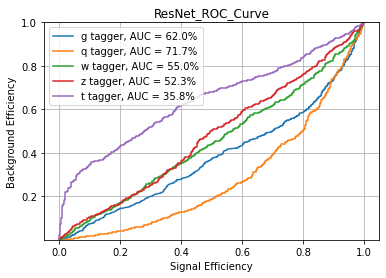

In [18]:
y_pred = makeRoc(X_test, y_test,labels, model, outputSuffix='ResNet')

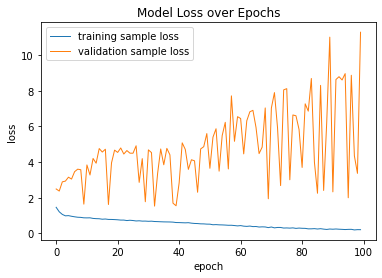

In [19]:
learningCurveLoss(history)

In [12]:
model.save('resnet_dgcnn_comparison.h5')
model.save_weights('resnet_dgcnn_comparison_weights.h5')

In [13]:
best_prediction = model.predict(X_test)

C:\Users\45148\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


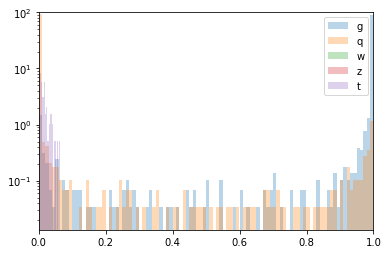

In [16]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=100)
plt.hist(best_prediction[:,0],**kwargs,label='g')
plt.hist(best_prediction[:,1],**kwargs,label='q')
plt.hist(best_prediction[:,2],**kwargs,label='w')
plt.hist(best_prediction[:,3],**kwargs,label='z')
plt.hist(best_prediction[:,4],**kwargs,label='t')
plt.yscale('log')
plt.xlim(0.0,1.0)
plt.ylim(0,100)
plt.legend(loc='upper right')